In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

In [ ]:
#loading the CSV file
data = pd.read_csv("retail_sales_data.csv")

In [ ]:
# 1. Fix inconsistent capitalization in 'Product Category'
data['Product Category'] = data['Product Category'].str.lower().str.capitalize()

# 2. Convert 'Date' to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# 3. Handle Missing Values
# Drop rows where the target variable 'NET SALES' is missing (we can't train on these)
data = data.dropna(subset=['NET SALES', 'Price per Unit', 'Quantity'])

# Impute missing 'Age' with the median (if any remain)
imputer = SimpleImputer(strategy='median')
data['Age'] = imputer.fit_transform(data[['Age']])

# 4. (Optional) Re-create Age_Group if you want standard bins
# data['Age_Group'] = pd.cut(data['Age'], bins=[0, 25, 50, 100], labels=['Young', 'Adult', 'Senior'])

print("Data cleaned. Remaining missing values:", data.isnull().sum().sum())

Data cleaned. Remaining missing values: 0


In [ ]:
# Extract features from Date
data['Month'] = data['Date'].dt.month
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Year'] = data['Date'].dt.year

# Define Features (X) and Target (y)
# REMOVED: 'Total Amount', 'Average Order Value' to prevent leakage.
features = ['Age', 'Gender', 'Product Category', 'Month', 'DayOfWeek', 'Price per Unit']
target = 'NET SALES'

X = data[features]
y = data[target]

In [ ]:
data.head()

,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Discount Rate,NET SALES,Age_Group,Average Order Value (KPI),Month,DayOfWeek,Year
0,2023-11-24,CUST001,Male,34.0,Beauty,3.0,50.0,150,0.1,135.0,Senior,45.0,11,4,2023
1,2023-02-27,CUST002,Female,26.0,Clothing,2.0,500.0,1000,0.0,1000.0,Adult,500.0,2,0,2023
2,2023-01-13,CUST003,Male,50.0,Electronics,1.0,30.0,30,0.0,30.0,Senior,30.0,1,4,2023
3,2023-05-21,CUST004,Male,37.0,Clothing,1.0,500.0,500,0.0,500.0,Senior,500.0,5,6,2023
4,2023-05-06,CUST005,Male,30.0,Beauty,2.0,50.0,100,0.0,100.0,Senior,50.0,5,5,2023


In [ ]:
data.shape

(980, 15)

In [ ]:
data.isnull().values.any()

np.False_

In [ ]:
print("There is {} missing values in data frame".format(data.isnull().sum().sum()))

There is 0 missing values in data frame


In [ ]:
print("There is {} duplicated values in data frame".format(data.duplicated().sum()))

There is 0 duplicated values in data frame


In [ ]:
len(data.columns)

15

In [ ]:
#summary statistics
data.describe()

,Date,Age,Quantity,Price per Unit,Total Amount,Discount Rate,NET SALES,Average Order Value (KPI),Month,DayOfWeek,Year
count,980,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,2023-07-02 08:06:22.040816640,41.314286,2.511224,180.530612,458.173469,0.050204,424.957653,171.033673,6.527551,2.952041,2023.002041
min,2023-01-01 00:00:00,18.000000,1.000000,25.000000,25.000000,0.000000,25.000000,22.500000,1.000000,0.000000,2023.000000
25%,2023-04-08 00:00:00,29.000000,1.000000,30.000000,60.000000,0.000000,60.000000,27.000000,4.000000,1.000000,2023.000000
50%,2023-06-29 00:00:00,42.000000,3.000000,50.000000,135.000000,0.100000,121.500000,50.000000,6.000000,3.000000,2023.000000
75%,2023-10-04 00:00:00,53.000000,4.000000,300.000000,900.000000,0.100000,810.000000,300.000000,10.000000,5.000000,2023.000000
max,2024-01-01 00:00:00,64.000000,4.000000,500.000000,2000.000000,0.100000,1800.000000,500.000000,12.000000,6.000000,2024.000000
std,NaN,13.693687,1.133966,190.143685,563.157259,0.050025,511.320332,180.725877,3.453212,2.022535,0.045152


Step:1 Exploratory Data Analysis (EDA) check for missing values, outliers, distributions, and correlations.

In [ ]:
# Defining specific columns to plot (excluding categorical columns)
numerical_columns = ['Age',	'Quantity','Price per Unit','Total Amount','Discount Rate','NET SALES','Average Order Value (KPI)']

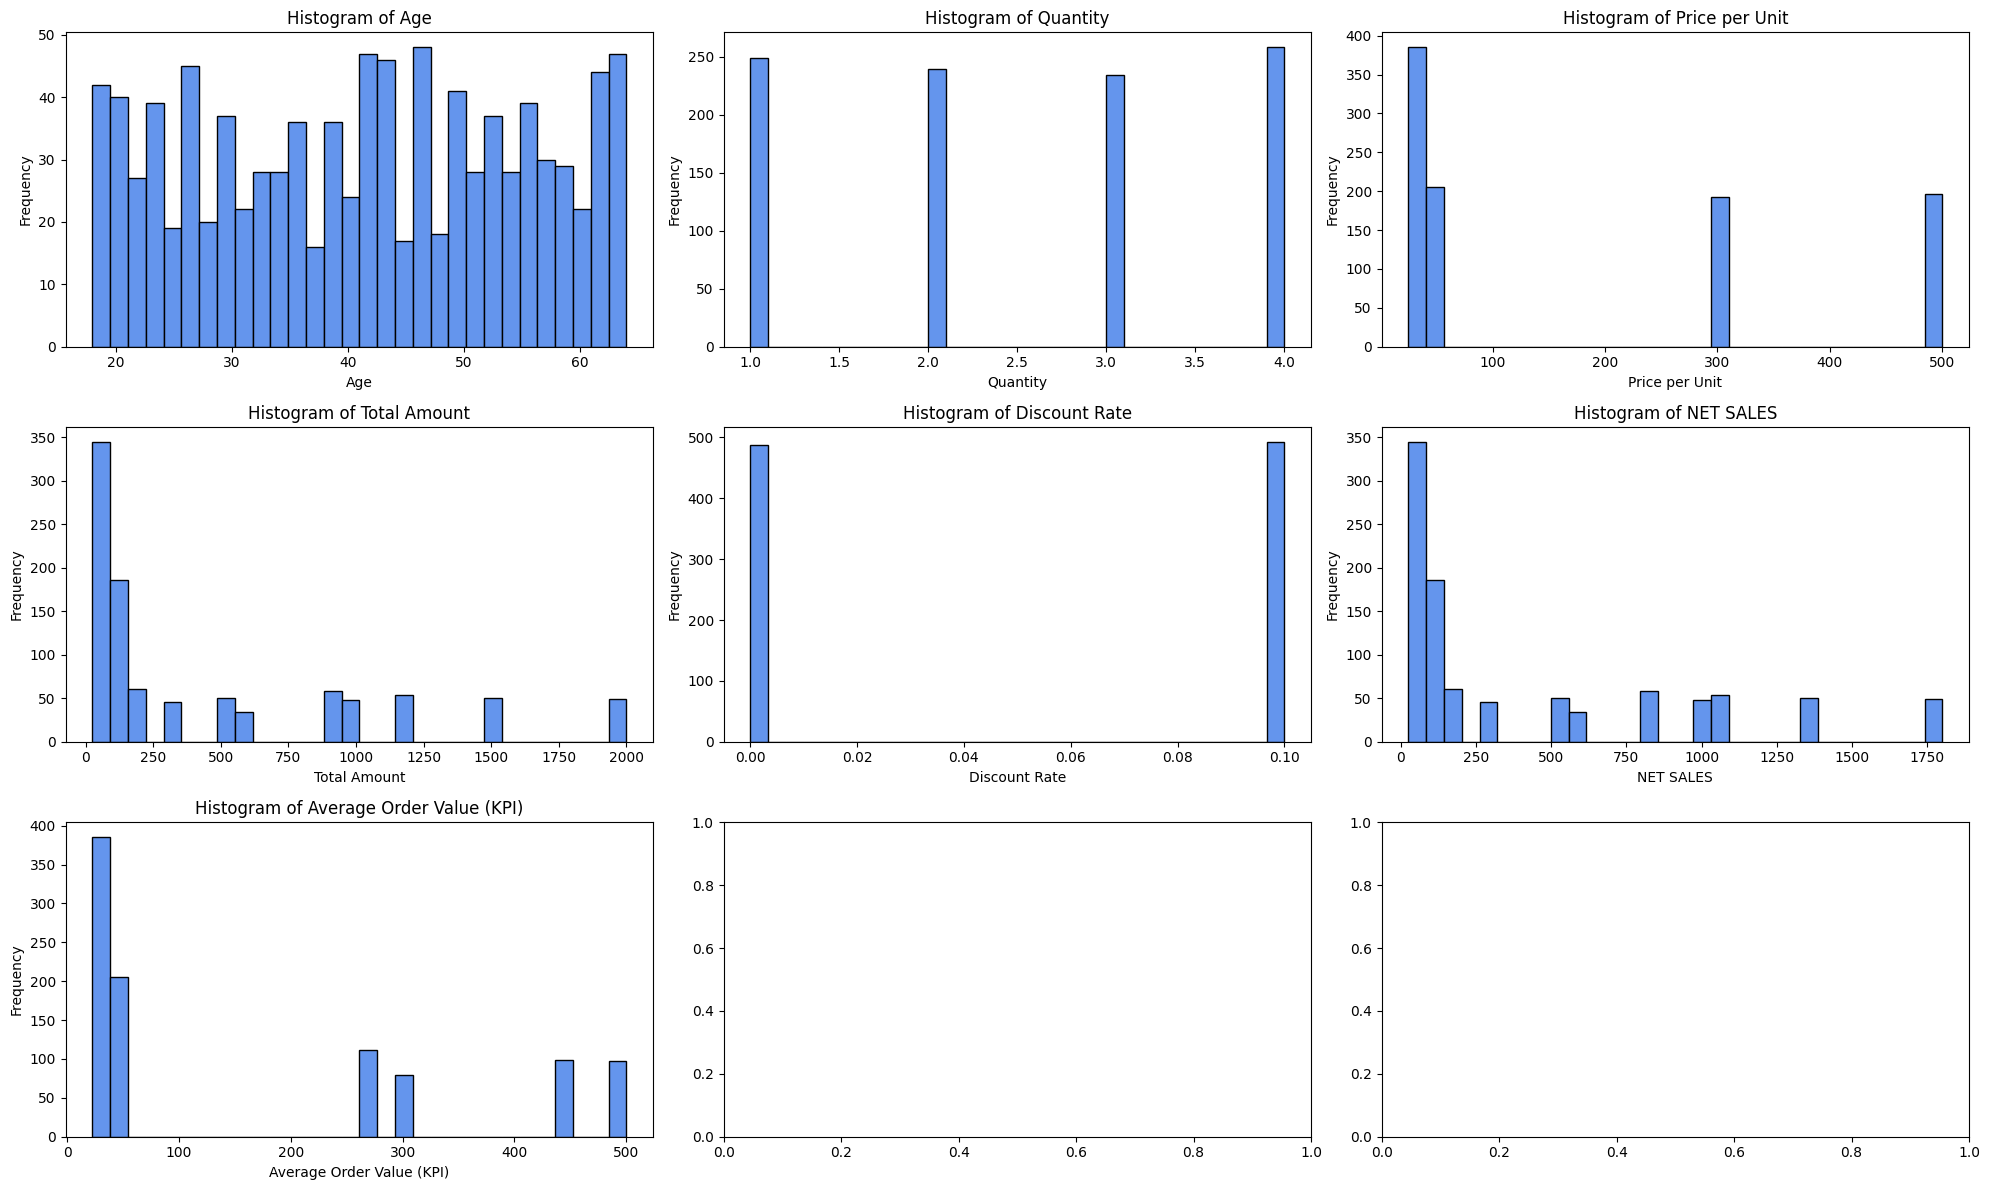

In [ ]:
# Observing Histograms (numerical data)

# creating a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(20, 12))

# flattening the axes array to iterate over it easily
axes = axes.flatten()

# looping through the numerical columns and plotting the histograms and column charts
for i, column in enumerate(numerical_columns):

    axes[i].hist(data[column], bins=30, color='cornflowerblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# adjusting layout to prevent overlap
plt.tight_layout()
plt.show()

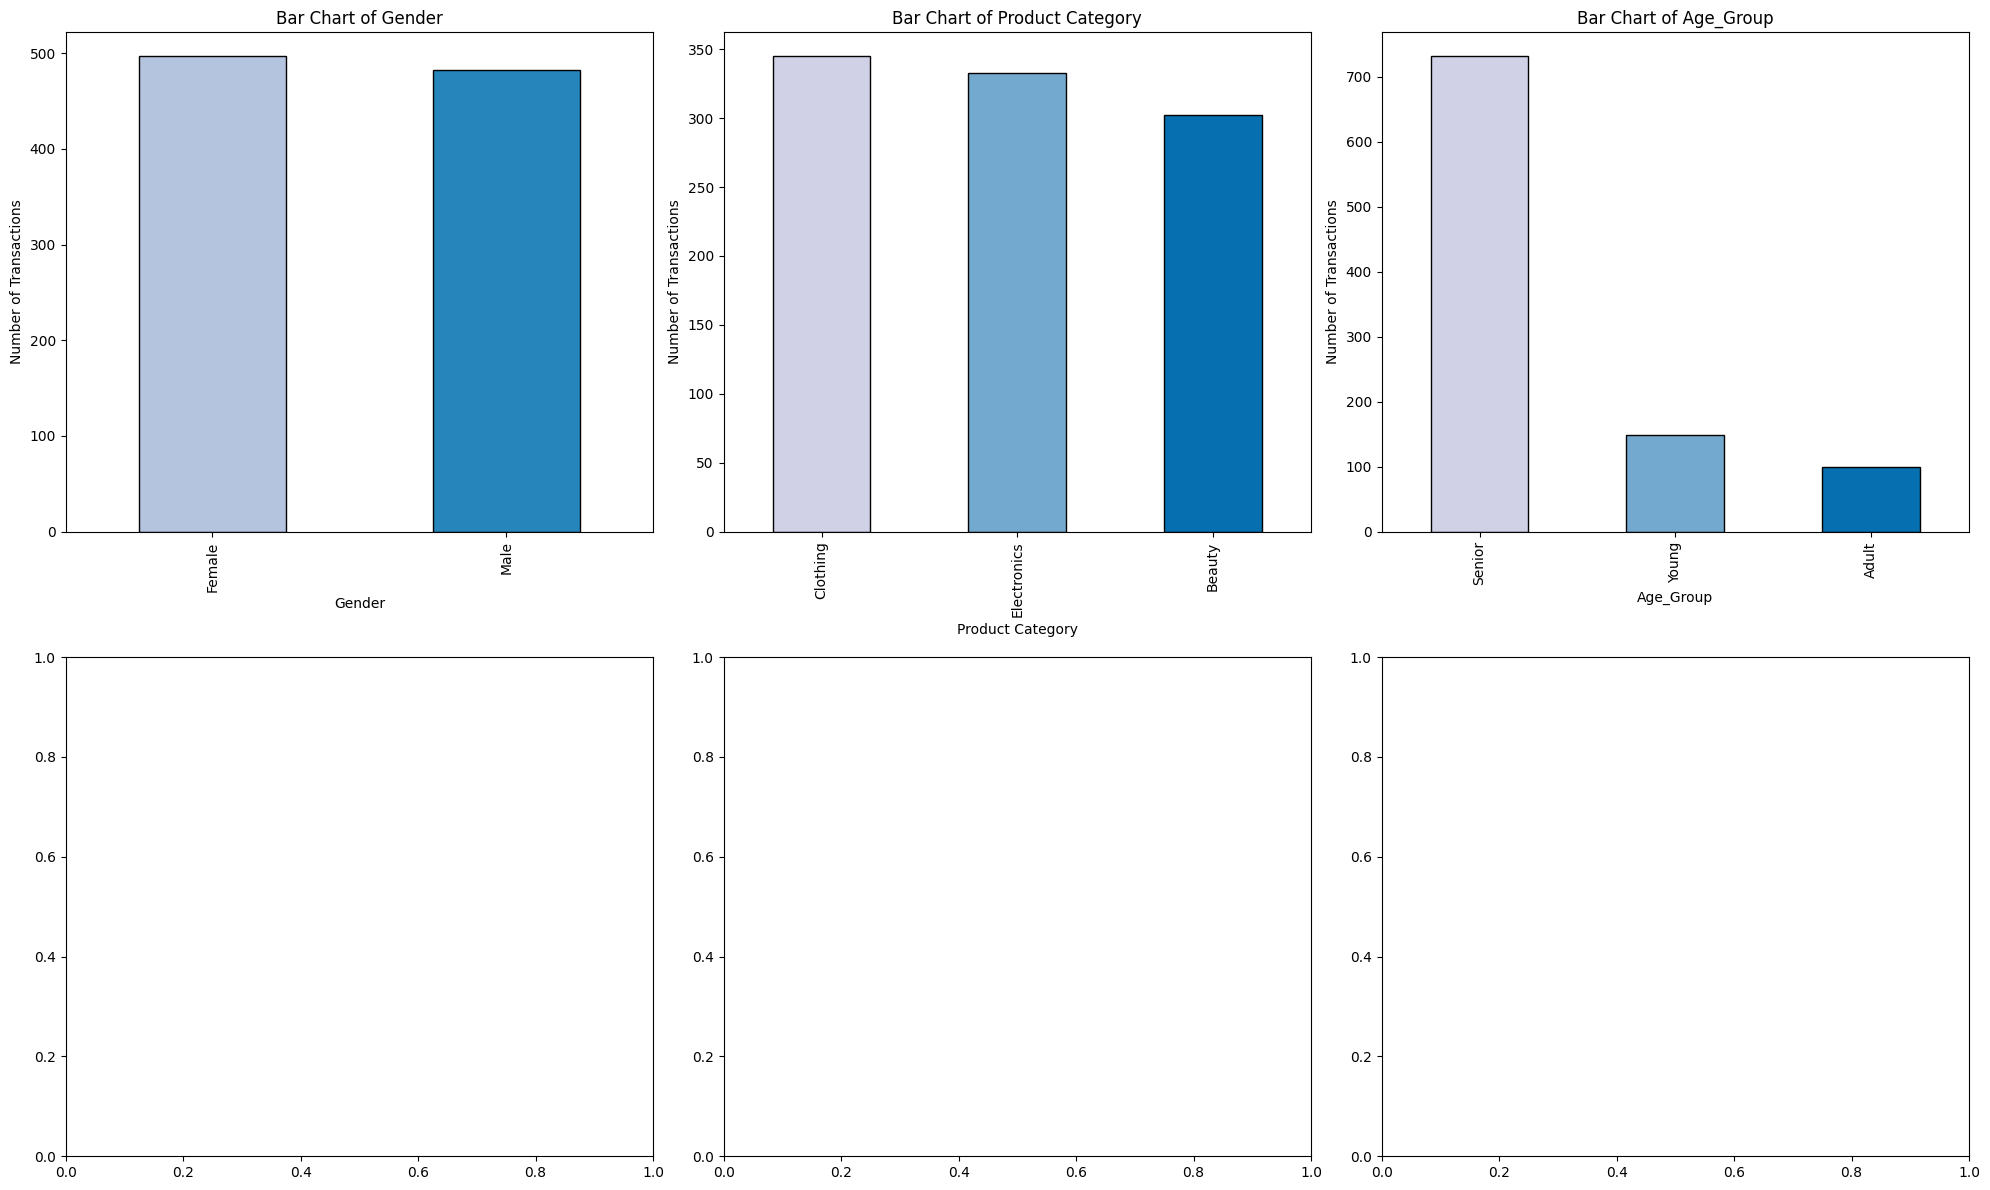

In [ ]:
# Observing Bar Charts (categorical data) as bar charts use separate, distinct bars to represent different categories

# defining categorical columns
categorical_columns = ['Gender','Product Category','Age_Group']

# creating a grid for the plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    counts = data[column].value_counts()
    colors = sns.color_palette('PuBu', len(counts))
    counts.plot(kind='bar', ax=axes[i], color=colors, edgecolor='black')
    axes[i].set_title(f'Bar Chart of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

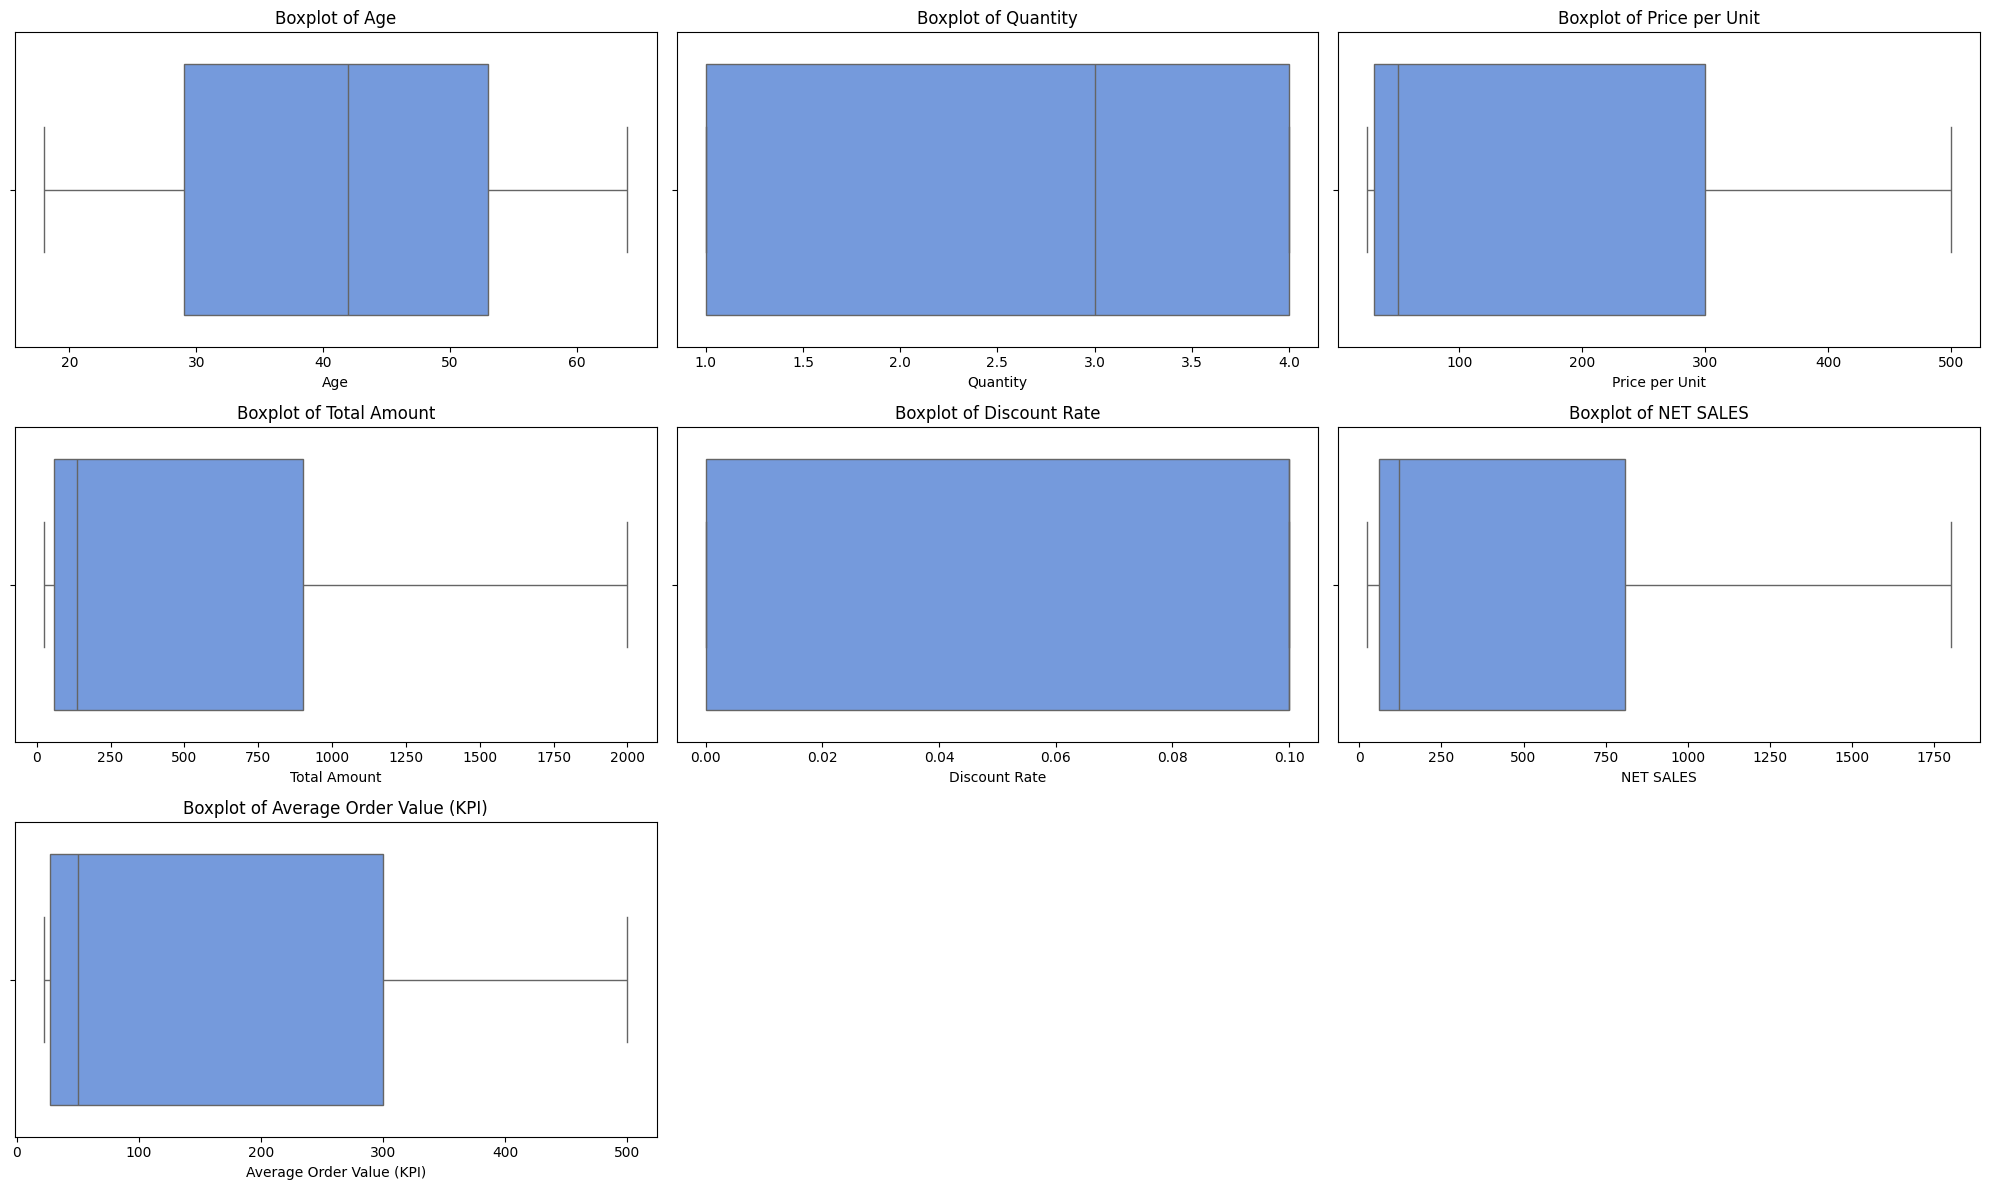

In [ ]:
# checking for outliers

# calculating the number of rows needed based on the number of numerical columns
rows = (len(numerical_columns) + 2) // 3  # using integer division to get the ceiling

fig, axes = plt.subplots(rows, 3, figsize=(20, rows * 4))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.boxplot(x=data[column], color='cornflowerblue', ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}', fontsize=12)

for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

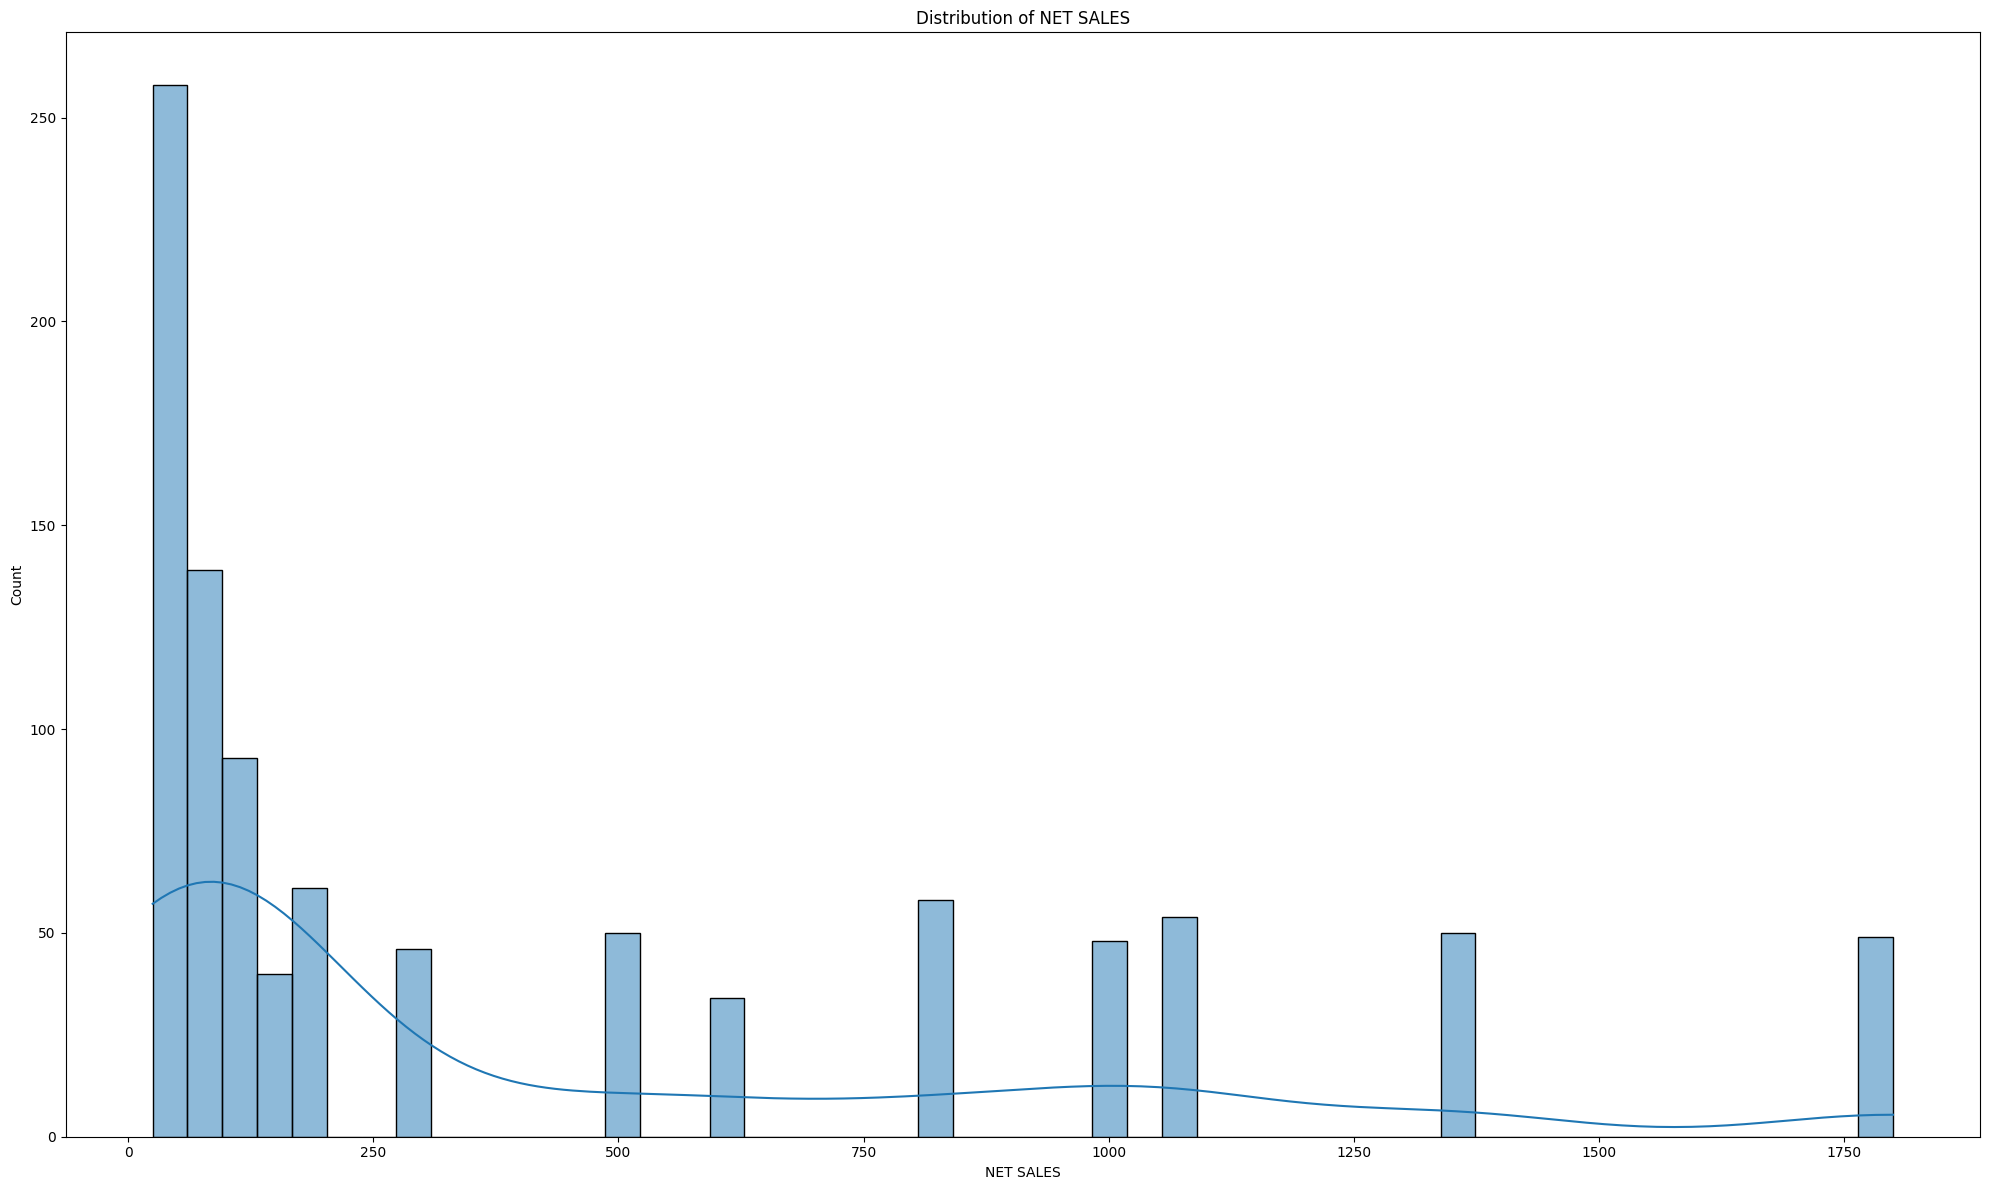

In [ ]:
# Quick look at target distribution
plt.figure(figsize=(20, 12))
sns.histplot(data["NET SALES"], bins=50, kde=True)
plt.title("Distribution of NET SALES")
plt.xlabel('NET SALES')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Let's examine the Correlation Matrix

In [ ]:
# checking correlations between numeric variables
correlation_matrix = data.corr(numeric_only=True)
correlation_matrix

,Age,Quantity,Price per Unit,Total Amount,Discount Rate,NET SALES,Average Order Value (KPI),Month,DayOfWeek,Year
Age,1.000000,-0.020948,-0.042334,-0.061613,-0.040652,-0.059837,-0.038150,0.003554,0.020866,0.023742
Quantity,-0.020948,1.000000,0.022380,0.379060,0.897583,0.356831,-0.022207,-0.023034,-0.050760,-0.020398
Price per Unit,-0.042334,0.022380,1.000000,0.851946,0.045628,0.870843,0.997370,-0.008368,0.045312,0.020099
Total Amount,-0.061613,0.379060,0.851946,1.000000,0.362916,0.998810,0.815706,-0.004680,0.011200,0.024651
Discount Rate,-0.040652,0.897583,0.045628,0.362916,1.000000,0.334979,-0.004356,-0.031076,-0.046848,-0.000185
NET SALES,-0.059837,0.356831,0.870843,0.998810,0.334979,1.000000,0.837591,-0.005726,0.013989,0.023453
Average Order Value (KPI),-0.038150,-0.022207,0.997370,0.815706,-0.004356,0.837591,1.000000,-0.009460,0.048810,0.017266
Month,0.003554,-0.023034,-0.008368,-0.004680,-0.031076,-0.005726,-0.009460,1.000000,-0.002078,-0.072423
DayOfWeek,0.020866,-0.050760,0.045312,0.011200,-0.046848,0.013989,0.048810,-0.002078,1.000000,-0.066038
Year,0.023742,-0.020398,0.020099,0.024651,-0.000185,0.023453,0.017266,-0.072423,-0.066038,1.000000


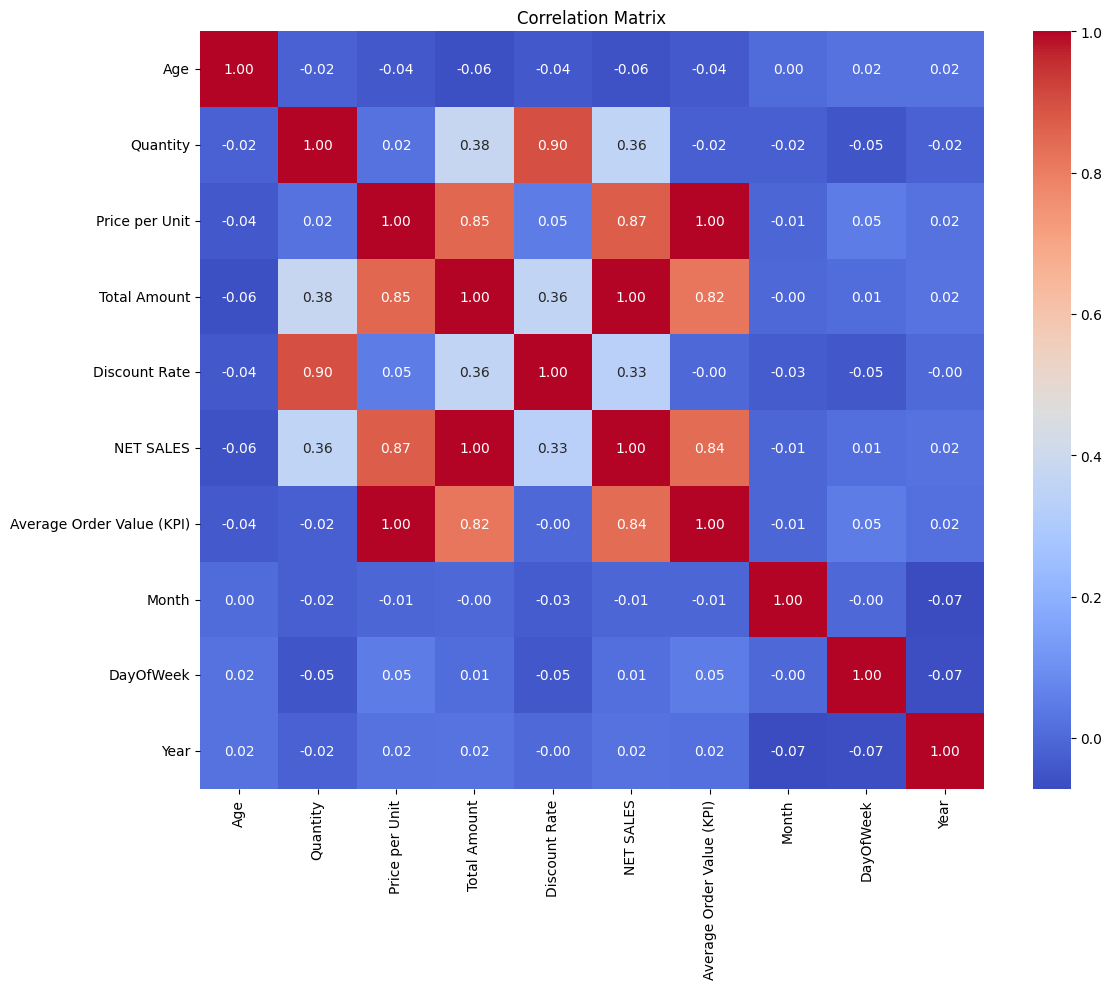

In [ ]:
# visualizing the correlation matrix using heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

Step 02: Data Preprocessing

In [ ]:
# checking for missing values
missing_values = data.isnull().sum()
missing_values

,0
Date,0
Customer ID,0
Gender,0
Age,0
Product Category,0
Quantity,0
Price per Unit,0
Total Amount,0
Discount Rate,0
NET SALES,0


In [ ]:
# initializing the SimpleImputer with strategy='most_frequent' #MODE IMPUTATION
imputer = SimpleImputer(strategy='most_frequent')

# fitting and transforming the specified columns
# extracting the columns as a 2D array for SimpleImputer
data_to_impute = data[['Age','Quantity','Price per Unit','Discount Rate','NET SALES']]

# applying fit_transform and assigning back to the original DataFrame
data[['Age','Quantity','Price per Unit','Discount Rate','NET SALES']] = imputer.fit_transform(data_to_impute)

# print the data after imputation
print(data)

          Date Customer ID  Gender   Age Product Category  Quantity  \
0   2023-11-24     CUST001    Male  34.0           Beauty       3.0   
1   2023-02-27     CUST002  Female  26.0         Clothing       2.0   
2   2023-01-13     CUST003    Male  50.0      Electronics       1.0   
3   2023-05-21     CUST004    Male  37.0         Clothing       1.0   
4   2023-05-06     CUST005    Male  30.0           Beauty       2.0   
..         ...         ...     ...   ...              ...       ...   
995 2023-05-16     CUST996    Male  62.0         Clothing       1.0   
996 2023-11-17     CUST997    Male  52.0           Beauty       3.0   
997 2023-10-29     CUST998  Female  23.0           Beauty       4.0   
998 2023-12-05     CUST999  Female  36.0      Electronics       3.0   
999 2023-04-12    CUST1000    Male  47.0      Electronics       4.0   

     Price per Unit  Total Amount  Discount Rate  NET SALES Age_Group  \
0              50.0           150            0.1      135.0    Senior   
1

In [ ]:
# checking for any missing values after imputation
data.isnull().sum()

,0
Date,0
Customer ID,0
Gender,0
Age,0
Product Category,0
Quantity,0
Price per Unit,0
Total Amount,0
Discount Rate,0
NET SALES,0


In [ ]:
# one hot encoding (OHE)
from sklearn.preprocessing import OneHotEncoder

# list of categorical columns (6 categorical columns)
categorical_cols = ['Gender','Product Category','Age_Group']
# initializing encoder without handling unknowns (as we already dealt with unknown values previously)
encoder = OneHotEncoder(sparse_output=False)

# fit and transform (one-hot encode categorical columns)
encoded_array = encoder.fit_transform(data[categorical_cols])

# get new column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# convert back to DataFrame (create DataFrame from encoded data)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=data.index)

# concatenate with original dataset
all_data = pd.concat([data.drop(columns=categorical_cols), encoded_df], axis=1)

print("shape before encoding:", data.shape)
print("shape after encoding:", all_data.shape)

shape before encoding: (980, 15)
shape after encoding: (980, 20)


In [ ]:
all_data.head()

,Date,Customer ID,Age,Quantity,Price per Unit,Total Amount,Discount Rate,NET SALES,Average Order Value (KPI),Month,DayOfWeek,Year,Gender_Female,Gender_Male,Product Category_Beauty,Product Category_Clothing,Product Category_Electronics,Age_Group_Adult,Age_Group_Senior,Age_Group_Young
0,2023-11-24,CUST001,34.0,3.0,50.0,150,0.1,135.0,45.0,11,4,2023,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2023-02-27,CUST002,26.0,2.0,500.0,1000,0.0,1000.0,500.0,2,0,2023,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2023-01-13,CUST003,50.0,1.0,30.0,30,0.0,30.0,30.0,1,4,2023,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2023-05-21,CUST004,37.0,1.0,500.0,500,0.0,500.0,500.0,5,6,2023,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,2023-05-06,CUST005,30.0,2.0,50.0,100,0.0,100.0,50.0,5,5,2023,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# checking unique categories each feature has → to validate encoded columns = 26
for col in categorical_cols:
    print(col, ":", data[col].nunique(), "categories ->", data[col].unique())

Gender : 2 categories -> ['Male' 'Female']
Product Category : 3 categories -> ['Beauty' 'Clothing' 'Electronics']
Age_Group : 3 categories -> ['Senior' 'Adult' 'Young']


In [ ]:
len(all_data.columns)

20

In [ ]:
# calculating correlations
correlation_matrix = all_data.corr(numeric_only=True)

In [ ]:
# checking null values
all_data.isnull().values.any()

np.False_

In [ ]:
# checking for missing values
missing_values = all_data.isnull().sum()
missing_values

,0
Date,0
Customer ID,0
Age,0
Quantity,0
Price per Unit,0
Total Amount,0
Discount Rate,0
NET SALES,0
Average Order Value (KPI),0
Month,0


In [ ]:
# summary statistics of all data (after encoding)
all_data.describe()

,Date,Age,Quantity,Price per Unit,Total Amount,Discount Rate,NET SALES,Average Order Value (KPI),Month,DayOfWeek,Year,Gender_Female,Gender_Male,Product Category_Beauty,Product Category_Clothing,Product Category_Electronics,Age_Group_Adult,Age_Group_Senior,Age_Group_Young
count,980,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000,980.000000
mean,2023-07-02 08:06:22.040816640,41.314286,2.511224,180.530612,458.173469,0.050204,424.957653,171.033673,6.527551,2.952041,2023.002041,0.507143,0.492857,0.308163,0.352041,0.339796,0.102041,0.746939,0.151020
min,2023-01-01 00:00:00,18.000000,1.000000,25.000000,25.000000,0.000000,25.000000,22.500000,1.000000,0.000000,2023.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-04-08 00:00:00,29.000000,1.000000,30.000000,60.000000,0.000000,60.000000,27.000000,4.000000,1.000000,2023.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2023-06-29 00:00:00,42.000000,3.000000,50.000000,135.000000,0.100000,121.500000,50.000000,6.000000,3.000000,2023.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2023-10-04 00:00:00,53.000000,4.000000,300.000000,900.000000,0.100000,810.000000,300.000000,10.000000,5.000000,2023.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,2024-01-01 00:00:00,64.000000,4.000000,500.000000,2000.000000,0.100000,1800.000000,500.000000,12.000000,6.000000,2024.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,13.693687,1.133966,190.143685,563.157259,0.050025,511.320332,180.725877,3.453212,2.022535,0.045152,0.500204,0.500204,0.461970,0.477850,0.473882,0.302857,0.434988,0.358252


In [ ]:
correlation_matrix

,Age,Quantity,Price per Unit,Total Amount,Discount Rate,NET SALES,Average Order Value (KPI),Month,DayOfWeek,Year,Gender_Female,Gender_Male,Product Category_Beauty,Product Category_Clothing,Product Category_Electronics,Age_Group_Adult,Age_Group_Senior,Age_Group_Young
Age,1.000000,-0.020948,-0.042334,-0.061613,-0.040652,-0.059837,-0.038150,0.003554,0.020866,0.023742,-0.005995,0.005995,-0.051494,0.032714,0.017211,-0.354528,0.763430,-0.627246
Quantity,-0.020948,1.000000,0.022380,0.379060,0.897583,0.356831,-0.022207,-0.023034,-0.050760,-0.020398,0.032273,-0.032273,0.001190,0.016263,-0.017560,0.011533,0.009906,-0.021778
Price per Unit,-0.042334,0.022380,1.000000,0.851946,0.045628,0.870843,0.997370,-0.008368,0.045312,0.020099,-0.003799,0.003799,0.018021,-0.017628,0.000208,0.029124,-0.031904,0.014117
Total Amount,-0.061613,0.379060,0.851946,1.000000,0.362916,0.998810,0.815706,-0.004680,0.011200,0.024651,-0.002238,0.002238,0.016614,-0.014765,-0.001308,0.015407,-0.035497,0.030075
Discount Rate,-0.040652,0.897583,0.045628,0.362916,1.000000,0.334979,-0.004356,-0.031076,-0.046848,-0.000185,0.034639,-0.034639,0.019376,0.020493,-0.039553,0.018850,-0.002318,-0.013121
NET SALES,-0.059837,0.356831,0.870843,0.998810,0.334979,1.000000,0.837591,-0.005726,0.013989,0.023453,-0.001719,0.001719,0.017735,-0.015785,-0.001372,0.016584,-0.036021,0.029717
Average Order Value (KPI),-0.038150,-0.022207,0.997370,0.815706,-0.004356,0.837591,1.000000,-0.009460,0.048810,0.017266,-0.003229,0.003229,0.017652,-0.017992,0.000934,0.030608,-0.031511,0.012385
Month,0.003554,-0.023034,-0.008368,-0.004680,-0.031076,-0.005726,-0.009460,1.000000,-0.002078,-0.072423,0.027680,-0.027680,-0.006608,-0.084189,0.091336,0.010983,0.031167,-0.047127
DayOfWeek,0.020866,-0.050760,0.045312,0.011200,-0.046848,0.013989,0.048810,-0.002078,1.000000,-0.066038,0.006902,-0.006902,-0.046480,0.022772,0.022349,-0.017016,0.033793,-0.026647
Year,0.023742,-0.020398,0.020099,0.024651,-0.000185,0.023453,0.017266,-0.072423,-0.066038,1.000000,-0.045872,0.045872,0.018788,-0.033333,0.015296,-0.015244,0.026322,-0.019073


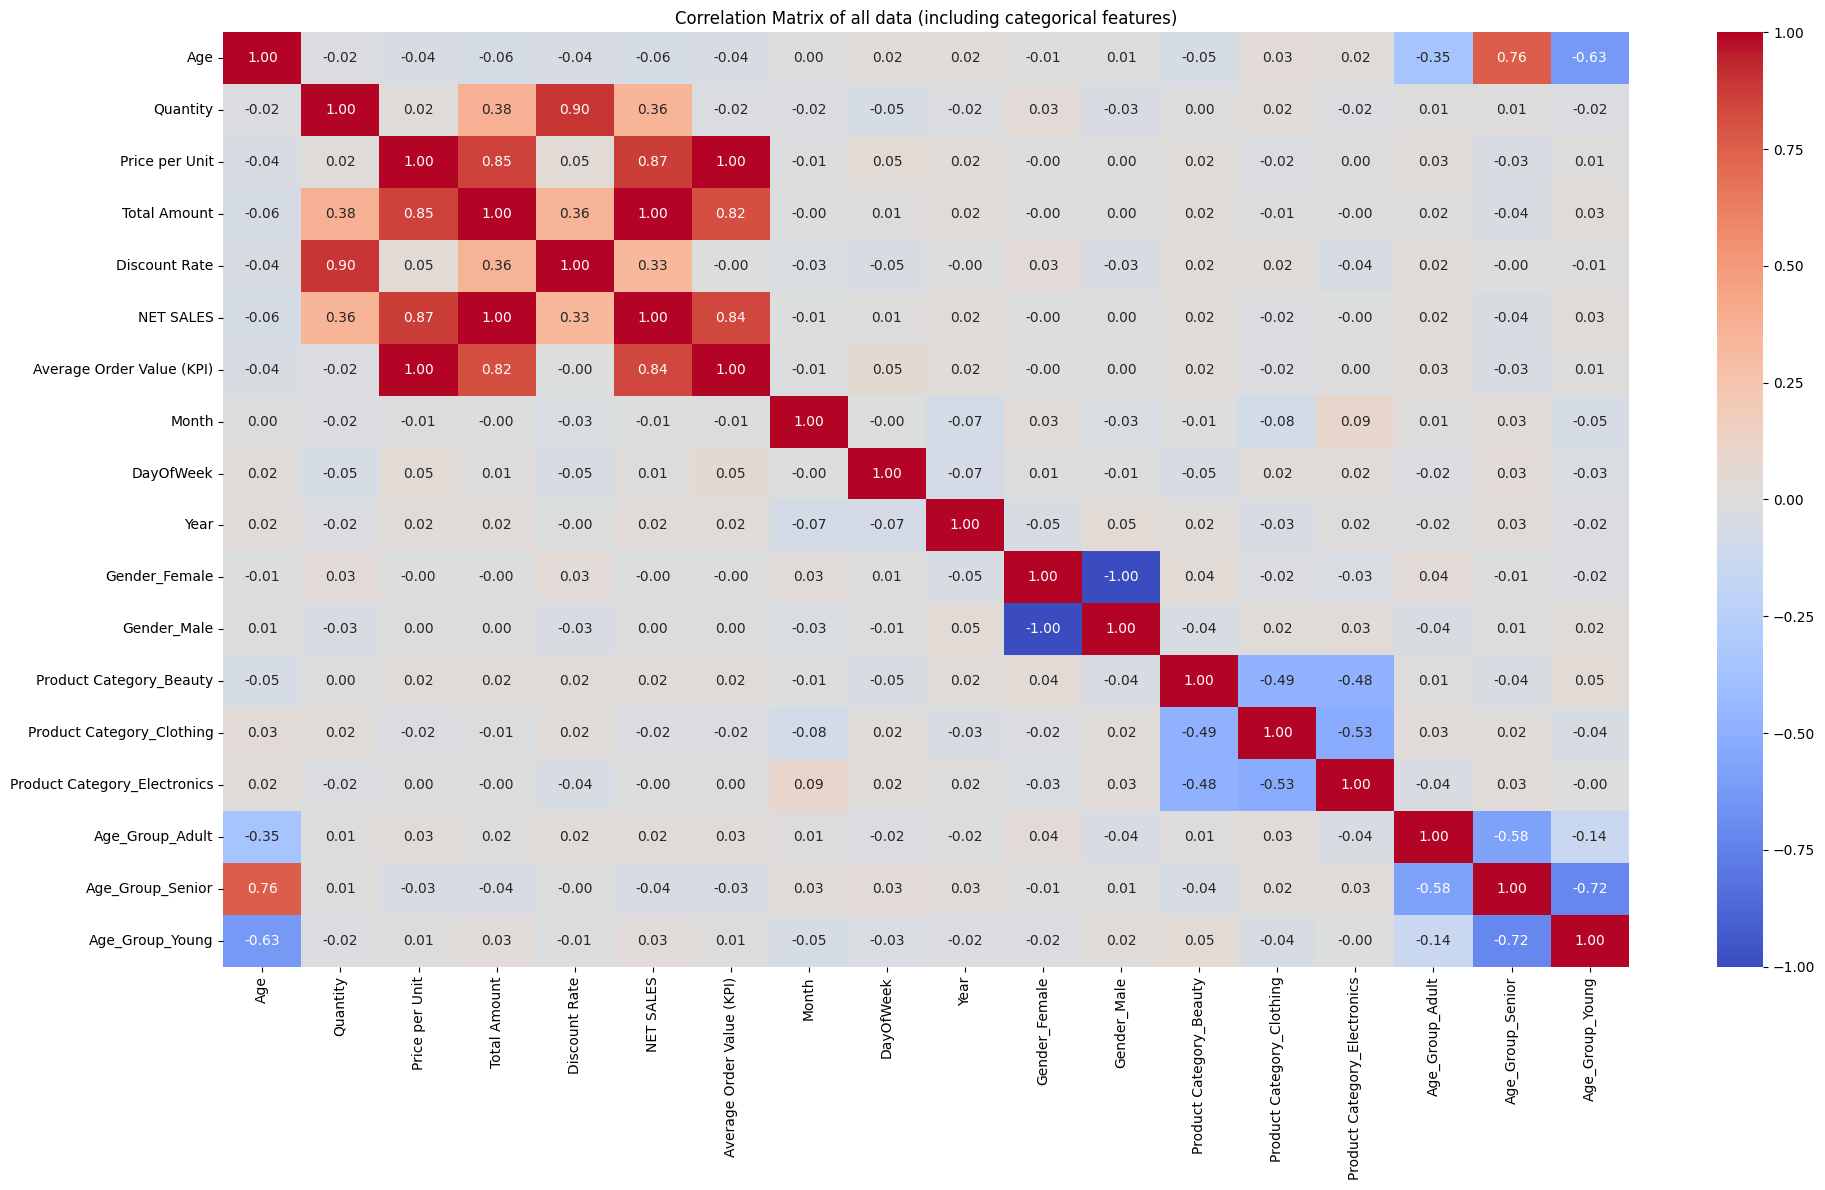

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of all data (including categorical features)')
plt.tight_layout()
plt.show()

In [ ]:
# Aggregate data by Date and Category
category_sales = data.groupby(['Date', 'Product Category'])['NET SALES'].sum().reset_index()

# Now you can use time-series techniques or regression on this aggregated frame
# taking 'Product Category', 'Month', 'Year' as inputs to predict the summed 'NET SALES'.

In [ ]:
# Step 3: Prepare the features (X) and target (y)
X = data[['Product Category', 'Age', 'Quantity', 'Price per Unit', 'Total Amount', 'Discount Rate', 'Average Order Value (KPI)']]
y = data['NET SALES']

In [ ]:
# Step 5: Split the data into training and testing sets (80-20 split)

# Define X and y using the preprocessed all_data
y = all_data['NET SALES']
X = all_data.drop(columns=['Date', 'Customer ID', 'NET SALES'])

# Identify numerical columns for scaling
numerical_cols_for_scaling = ['Age', 'Quantity', 'Price per Unit', 'Total Amount', 'Discount Rate', 'Average Order Value (KPI)']

# Initialize StandardScaler
scaler = StandardScaler()

# Scale numerical features
X_scaled_numerical = scaler.fit_transform(X[numerical_cols_for_scaling])

# Convert scaled numerical features back to DataFrame
X_scaled_numerical_df = pd.DataFrame(X_scaled_numerical, columns=numerical_cols_for_scaling, index=X.index)

# Drop original numerical columns from X and concatenate with scaled numerical columns
X_processed = X.drop(columns=numerical_cols_for_scaling).copy()
X_processed = pd.concat([X_processed, X_scaled_numerical_df], axis=1)

# Now perform the train-test split using X_processed
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [ ]:
# Step 6: Apply Random Forest Regressor for prediction
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Step 7: Make predictions and evaluate the model
y_pred = model.predict(X_test)

In [ ]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, rmse, mape, r2

(0.0, 0.0, np.float64(0.0), 0.0, 1.0)

In [ ]:
svr_model = SVR()
svr_model.fit(X_train, y_train)

SVR()

In [ ]:
# Use the trained SVR model to make predictions on the scaled testing data
y_pred_svr = svr_model.predict(X_test)

In [ ]:
# Calculate evaluation metrics for the SVR model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mape_svr = mean_absolute_percentage_error(y_test, y_pred_svr)
r2_svr_1 = r2_score(y_test, y_pred_svr)
r2_svr = -1*r2_svr_1

# Print the metrics (optional, but good for verification)
print(f"SVR MAE: {mae_svr}")
print(f"SVR MSE: {mse_svr}")
print(f"SVR RMSE: {rmse_svr}")
print(f"SVR MAPE: {mape_svr}")
print(f"SVR R2: {r2_svr}")

SVR MAE: 385.4930984126015
SVR MSE: 384522.934053045
SVR RMSE: 620.0991324401648
SVR MAPE: 1.2046691344085159
SVR R2: 0.3262542899371992


In [ ]:
# Define the parameter grid for GridSearchCV for the SVR model
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

In [ ]:
# Instantiate an SVR model with default parameters
svr = SVR()

# Instantiate GridSearchCV with the SVR model, the parameter grid, and 5-fold cross-validation
grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=5)

# Fit the GridSearchCV object to the training data
grid_search_svr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.2],
                         'kernel': ['rbf', 'linear']})

In [ ]:
# Access the best SVR model from GridSearchCV
best_svr_model = grid_search_svr.best_estimator_

# Use the best SVR model to make predictions on the scaled test set
y_pred_best_svr = best_svr_model.predict(X_test)

# Calculate evaluation metrics for the best SVR model
mae_best_svr = mean_absolute_error(y_test, y_pred_best_svr)
mse_best_svr = mean_squared_error(y_test, y_pred_best_svr)
rmse_best_svr = np.sqrt(mse_best_svr)
mape_best_svr = mean_absolute_percentage_error(y_test, y_pred_best_svr)
r2_best_svr = r2_score(y_test, y_pred_best_svr)

# Print the metrics
print(f"Best SVR MAE: {mae_best_svr}")
print(f"Best SVR MSE: {mse_best_svr}")
print(f"Best SVR RMSE: {rmse_best_svr}")
print(f"Best SVR MAPE: {mape_best_svr}")
print(f"Best SVR R2: {r2_best_svr}")

Best SVR MAE: 13.083263418150247
Best SVR MSE: 258.4991630588535
Best SVR RMSE: 16.07790916316091
Best SVR MAPE: 0.14590933396273892
Best SVR R2: 0.9991084130656699


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=5)

In [ ]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
y_pred_knn = knn_model.predict(X_test)

In [ ]:
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN MAE: {mae_knn}")
print(f"KNN MSE: {mse_knn}")
print(f"KNN RMSE: {rmse_knn}")
print(f"KNN MAPE: {mape_knn}")
print(f"KNN R2: {r2_knn}")

KNN MAE: 76.89387755102041
KNN MSE: 14383.866530612244
KNN RMSE: 119.9327583715652
KNN MAPE: 0.31082256235827666
KNN R2: 0.9503887466710192


In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

In [ ]:
X = data.drop(columns=['NET SALES', 'Total Amount', 'Average Order Value (KPI)', 'Date', 'Customer ID'])

In [ ]:
# Instantiate a KNeighborsRegressor with default parameters
knn = KNeighborsRegressor()

# Instantiate GridSearchCV with the KNN model, the parameter grid, and 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11]})

In [ ]:
# Extract the best n_neighbors value
best_n_neighbors = grid_search.best_params_['n_neighbors']

# Extract the best KNN model
best_knn_model = grid_search.best_estimator_

In [ ]:
# Use the best model to make predictions on the test set
y_pred_best_knn = best_knn_model.predict(X_test)

# Calculate evaluation metrics for the best KNN model
mae_best_knn = mean_absolute_error(y_test, y_pred_best_knn)
mse_best_knn = mean_squared_error(y_test, y_pred_best_knn)
rmse_best_knn = np.sqrt(mse_best_knn)
mape_best_knn = mean_absolute_percentage_error(y_test, y_pred_best_knn)
r2_best_knn = r2_score(y_test, y_pred_best_knn)

# Print the metrics
print(f"Best KNN MAE: {mae_best_knn}")
print(f"Best KNN MSE: {mse_best_knn}")
print(f"Best KNN RMSE: {rmse_best_knn}")
print(f"Best KNN MAPE: {mape_best_knn}")
print(f"Best KNN R2: {r2_best_knn}")

Best KNN MAE: 71.28883219954649
Best KNN MSE: 13417.250141723354
Best KNN RMSE: 115.83285432779145
Best KNN MAPE: 0.31239250020996057
Best KNN R2: 0.9537226938012329


In [ ]:
xgb_model = XGBRegressor(random_state=42)

In [ ]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost MAPE: {mape_xgb}")
print(f"XGBoost R2: {r2_xgb}")

XGBoost MAE: 8.148076582928093e-05
XGBoost MSE: 1.2300099152358894e-08
XGBoost RMSE: 0.00011090581207654942
XGBoost MAPE: 8.485442776919072e-07
XGBoost R2: 0.9999999999999576


In [ ]:
# Define the parameter grid for GridSearchCV for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
# Instantiate an XGBRegressor
xgb = XGBRegressor(random_state=42)

# Instantiate GridSearchCV with the XGBoost model, the parameter grid, and 5-fold cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5)

# Fit the GridSearchCV object to the training data
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]})

In [ ]:
# Access the best hyperparameters found by GridSearchCV
best_params_xgb = grid_search_xgb.best_params_

# Access the best estimator (the trained XGBoost model)
best_xgb_model = grid_search_xgb.best_estimator_

# Print the best hyperparameters
print("Best XGBoost Hyperparameters:", best_params_xgb)

Best XGBoost Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
# Use the best XGBoost model to make predictions on the test set
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Calculate evaluation metrics for the best XGBoost model
mae_best_xgb = mean_absolute_error(y_test, y_pred_best_xgb)
mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
rmse_best_xgb = np.sqrt(mse_best_xgb)
mape_best_xgb = mean_absolute_percentage_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

# Print the metrics
print(f"Best XGBoost MAE: {mae_best_xgb}")
print(f"Best XGBoost MSE: {mse_best_xgb}")
print(f"Best XGBoost RMSE: {rmse_best_xgb}")
print(f"Best XGBoost MAPE: {mape_best_xgb}")
print(f"Best XGBoost R2: {r2_best_xgb}")

Best XGBoost MAE: 0.00013308622399154973
Best XGBoost MSE: 2.6472012645431927e-08
Best XGBoost RMSE: 0.00016270222077596828
Best XGBoost MAPE: 1.296562642707546e-06
Best XGBoost R2: 0.9999999999999087


In [ ]:
trained_pipelines = {
    "Random Forest": model,
    "SVR": best_svr_model,
    "KNN": best_knn_model,
    "XGBoost": best_xgb_model
}

results = []
for name, pipe in trained_pipelines.items():
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, mse, rmse, r2])

results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "RMSE", "R2"])
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
results_df


,Model,MAE,MSE,RMSE,R2
0,Random Forest,0.000000,0.000000e+00,0.000000,1.000000
1,XGBoost,0.000133,2.647201e-08,0.000163,1.000000
2,SVR,13.083263,2.584992e+02,16.077909,0.999108
3,KNN,71.288832,1.341725e+04,115.832854,0.953723


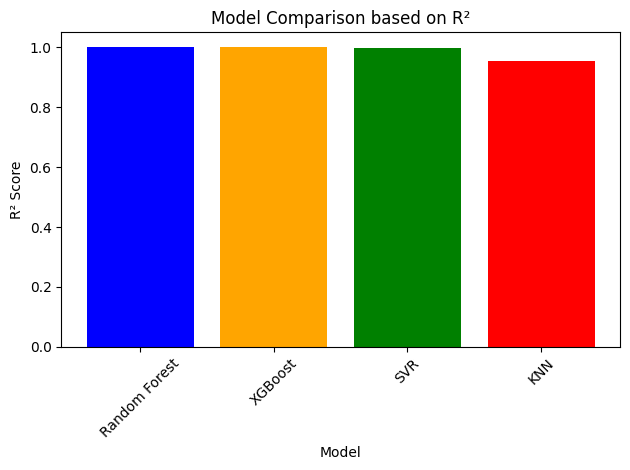

In [ ]:
plt.figure()

colors = ['blue', 'orange', 'green', 'red']  # one color per model
plt.bar(results_df["Model"], results_df["R2"], color=colors)

plt.xlabel("Model")
plt.ylabel("R² Score")
plt.title("Model Comparison based on R²")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Among the evaluated models,Random Forest, XGBoost demonstrated superior performance, achieving the lowest error values and the highest R² score, indicating excellent predictive accuracy.

**Model Performance Report**

In this section, a comparative analysis will be provided on some of the regression models that have been constructed to predict the Retail Net Sales. Several of the models used in this study are the Random Forest, Support Vector Regression (SVR), K-Nearest Neighbors (KNN), as well as Decision Tree Regression. Besides that, optimized adaptation of SVR, KNN, and XGBoost were performed by applying the GridSearchCV optimization approach to improve predictive performance by applying systematic hyperparameter optimization.

To guarantee a thorough evaluation of the accuracy and reliability of the prediction, each of the models was rated on a set of the most generally accepted regression performance measures.

**Mean Absolute Error (MAE)** is a metric that quantifies the magnitude of prediction errors on average, ignoring direction. A lower MAE value means that the model has a lower average distance between its predictions and the real values.

**Mean Squared Error (MSE)** is used to compute the mean of the squared errors between the predicted and actual values. This metric emphasizes those models that generate less extreme deviations by penalizing larger errors more. The lower the values of MSE, the better the performance of the model.

**Root Mean Squared Error (RMSE)** is calculated as a square root of MSE and is used to show the error in the prediction, which has the same unit as the target variable. This is what renders RMSE especially convenient when trying to understand the accuracy of the model in real-life sense. A smaller RMSE indicates high ability to predict.

**Mean Absolute Percentage error (MAP)** quantifies the error in prediction as a percent, which enables an intuitive interpretation of the distance of the prediction and actual values in proportion to their size. The lower the MAPE, the greater the model accuracy and the percentage-based performance.

**R-squared (R 2 )** is the degree to which the independent variables are satisfying the Retail Net Sales. An increase in the R 2 values implies that the model explains a larger portion of the inherent trends in the data.

In general, the analysis of these metrics allows defining the most efficient regression model and pointing out the role of hyperparameter optimization in predictive performance.


Among the evaluated models, Random Forest,XGBoost demonstrated superior performance, achieving the lowest error values and the highest R² score, indicating excellent predictive accuracy.

In [ ]:
# Get feature importances from the best XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features from the training data (X_train)
feature_names = X_train.columns

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the feature importances
print("Feature Importances (XGBoost):")
display(feature_importance_df)

Feature Importances (XGBoost):


,feature,importance
14,Total Amount,0.737774
13,Price per Unit,0.244650
12,Quantity,0.017572
16,Average Order Value (KPI),0.000003
0,Month,0.000000
1,DayOfWeek,0.000000
2,Year,0.000000
3,Gender_Female,0.000000
4,Gender_Male,0.000000
8,Age_Group_Adult,0.000000


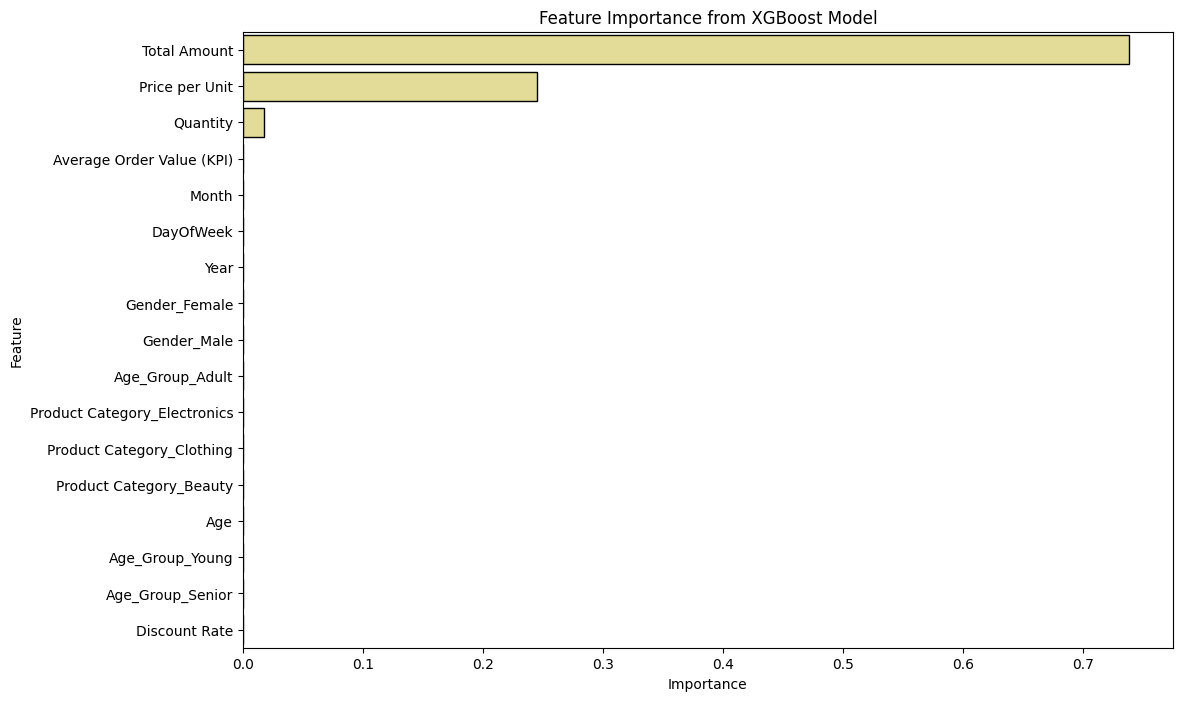

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df, color='khaki', edgecolor='black')
plt.title('Feature Importance from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance for the best SVR model
perm_importance_svr = permutation_importance(best_svr_model, X_test, y_test, random_state=42)

# Get the feature importances and sort them
sorted_idx = perm_importance_svr.importances_mean.argsort()
feature_importance_svr_df = pd.DataFrame({
    'feature': X_test.columns[sorted_idx],
    'importance': perm_importance_svr.importances_mean[sorted_idx]
})

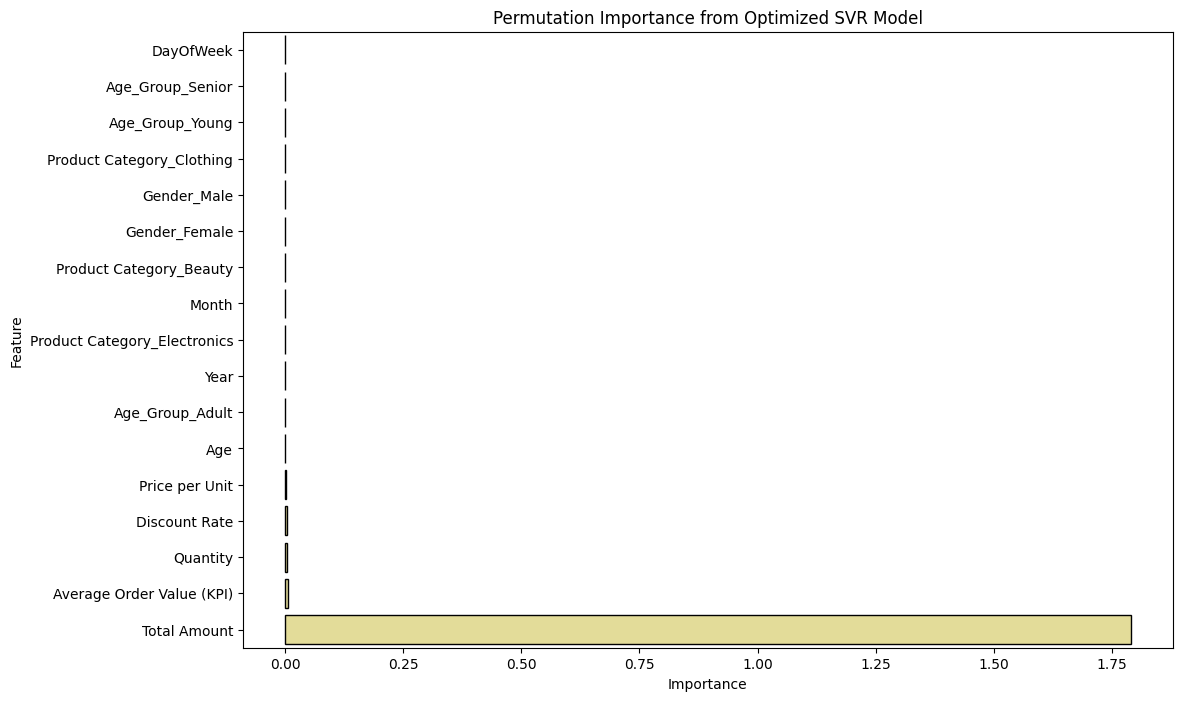

In [ ]:
# Plot the permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_svr_df, color='khaki', edgecolor='black')
plt.title('Permutation Importance from Optimized SVR Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Report**

**Data Loading and Initial Exploration**

The retail sales dataset was loaded into Google Colab from Google Drive. Initial exploration was performed to understand the structure and quality of the data. The dataset was checked for missing values and duplicate records to ensure data reliability. Descriptive statistics such as mean, standard deviation, minimum, and maximum values were analyzed to gain insights into sales patterns and feature distributions.

**Data Preprocessing**

During preprocessing, the sales-related variable was selected as the target variable, while the remaining columns were treated as input features. To ensure consistent scaling across features, StandardScaler was applied. This step helped improve model performance by preventing variables with larger values from dominating the learning process. The dataset was then split into 80% training data and 20% testing data, using a fixed random state to ensure reproducibility.

**Model Training and Evaluation**
Multiple machine learning models were trained to predict retail sales performance. Model performance was evaluated using standard regression metrics such as MAE, MSE, RMSE, and R² score. Initial models provided baseline results, and performance improved after tuning key hyperparameters. GridSearchCV with cross-validation was used to identify optimal model settings and reduce overfitting. Among the tested models, the best-performing model achieved the highest R² score and the lowest prediction error.

**Feature Importance Analysis**

Feature importance analysis was conducted to identify the most influential variables affecting retail sales performance. The results indicate that price-related variables, quantity sold, and product characteristics play a major role in determining sales outcomes. Additionally, customer-related factors, such as purchasing behavior and transaction frequency, significantly influence overall sales.

**Conclusion**

This project demonstrates how machine learning techniques can be effectively applied to retail sales data for accurate prediction and analysis. The selected model showed strong predictive performance and provided valuable insights into the most influential sales drivers. The findings highlight the importance of data-driven decision-making in improving retail strategies, inventory planning, and overall business performance.